## importings 

In [1]:
import pandas as pd
import numpy as np

## Chose a ticker

In [2]:
ticker="AMZN"

## Stocks Data

In [43]:
# get the stock data
from google.cloud import storage
def get_stock_data_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/stock_prices"
    df_stocks = pd.read_csv(path, sep="\t")#add nrows after if you want to select a specific number of row
    df_stocks.rename(columns={"Unnamed: 0":"date"}, inplace=True)
    df = df_stocks.sort_values(["date"], ascending=True)
    
    if ticker:
        df = df_stocks[["date", ticker]]
        df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True)
        
    return df


In [44]:
#df_stocks = get_stock_data_from_gcp()

In [45]:
#df_stocks

In [46]:
df_stocks = get_stock_data_from_gcp(ticker=ticker)

/tmp/ipykernel_7840/1200910319.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [ ]:
df_stocks

## Get the sentiment

In [ ]:
# get the data from GCP
from google.cloud import storage
def get_sentiment_news_data_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/final_stocks_sentiment_21221.csv"
    sentiment = pd.read_csv(path)#add nrows after if you want to select a specific number of row
    sentiment = sentiment[['date', 'ticker', 'news_label']]
    sentiment["date"] = pd.to_datetime(sentiment["date"] , infer_datetime_format=True)
    sentiment.set_index(["date"], inplace=True)
    if ticker:
        sentiment_ticker = sentiment[sentiment['ticker'] == ticker]
        sentiment_ticker.drop(columns=['ticker'], inplace=True)
        return sentiment_ticker
    else:
        return sentiment

In [ ]:
sentiment = get_sentiment_news_data_from_gcp(ticker=ticker)

In [ ]:
sentiment

## Get Twitter Data

In [ ]:
from google.cloud import storage
def get_twitter_stocks_sentiment_from_gcp(nrows=10000, local=False, optimize=False, ticker=None, **kwargs):
    """method to get the training data (or a portion of it) from google cloud bucket"""
    # Add Client() here
    client = storage.Client()
    if local:
        path = "data/data_data_10Mill.csv"
    else:
        path = "gs://stock-news-pred-bucket/Amazon1 twitter_stocks_sentiment.csv"
    
    if ticker=="AMZN":
        path = "gs://stock-news-pred-bucket/Amazon1 twitter_stocks_sentiment.csv"
    if ticker=="GOOGL":
        path = "gs://stock-news-pred-bucket/Google1 twitter_stocks_sentiment.csv"
    if ticker=="MSFT":
        path = "gs://stock-news-pred-bucket/Microsoft1 twitter_stocks_sentiment.csv"
    if ticker=="NFLX":
        path="gs://stock-news-pred-bucket/Netflix1 twitter_stocks_sentiment.csv"
        
    df = pd.read_csv(path, index_col= False)#add nrows after if you want to select a specific number of row
    df.drop(columns=["Unnamed: 0"], inplace=True)
    df.rename(columns={"class_label": "twitter_label"}, inplace=True)
    df["date"] = pd.to_datetime(df["date"] , infer_datetime_format=True)

    return df

In [ ]:
df_twitter = get_twitter_stocks_sentiment_from_gcp(ticker=ticker)
df_twitter

## Merging Datasets

In [ ]:
def merge_data(df_stocks, df_news, df_twitter):
    df = pd.merge(df_stocks, df_news, on='date', how='outer')
    df_twitter_merge = pd.merge(df, df_twitter, on='date', how='outer')
    df_twitter_merge.rename(columns={"class_label": "news_label"}, inplace= True)
    df_twitter_merge.sort_values(["date"], inplace=True)
    mask = df_twitter_merge["news_label"].notnull()==True
    new_df = df_twitter_merge[mask]
    new_df.iloc[:,1].interpolate(method= "linear", inplace= True)
    #min_date = new_df["date"].min()
    #new_df = df.loc[min_date:,:]
    new_df.fillna(value=-1, inplace=True)
    
    return new_df

In [ ]:
df = merge_data(df_stocks, sentiment, df_twitter)

In [ ]:
df

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# INSTANTIATE THE SCALER
scaler = MinMaxScaler()

# FIT IT ONLY ON AMZN
scaler.fit(df[[ticker]])

# LET'S CREATE A COPY OF MERGED_DF
data_scaled = df.copy()


In [ ]:
# AND TRANSFORM ONLY THE AMZN COLUMN
data_scaled[ticker] = scaler.transform(data_scaled[[ticker]])

# NOW LOOK AT DATA_SCALED
data_scaled.tail(20)

In [ ]:
data_scaled.to_csv(f"scaled_for_{ticker}")

## prepare the LSTM Model

In [15]:
data_scaled = pd.read_csv("scaled_for_GOOGL")
ticker="GOOGL"

In [19]:
data_scaled.drop(columns="Unnamed: 0", inplace=True)

In [16]:
# SETTING THE DATE AS INDEX
data_scaled.set_index(["date"], inplace= True)

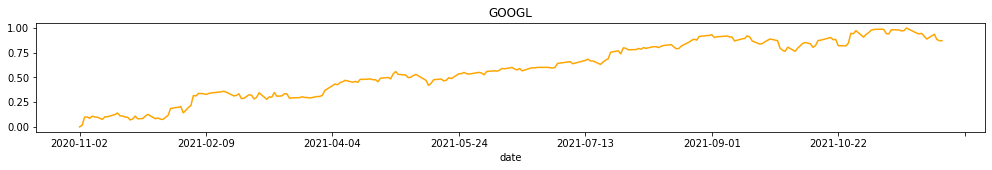

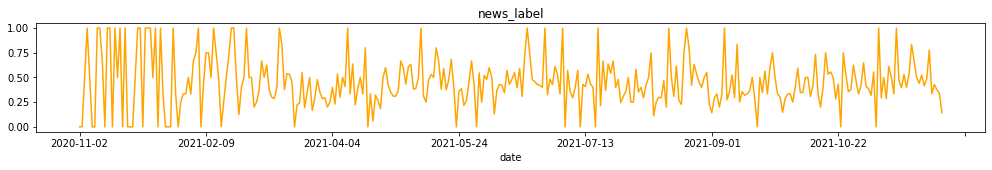

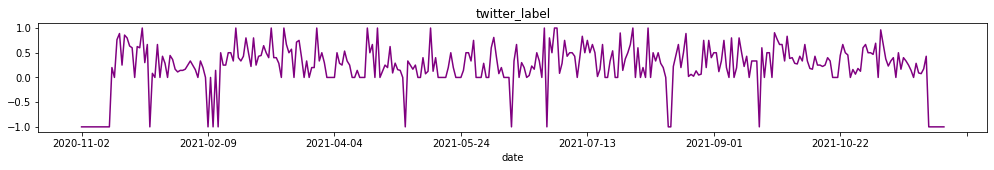

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

for column in data_scaled.columns:
    if column == ticker: color = "orange"
    if column == "class_label": color = "blue" 
    if column == "twitter_label": color = "purple" 
    data_scaled[column].plot(figsize=(17, 2), color=color)
    plt.title(column)
    plt.show()

In [22]:
data_scaled = data_scaled.drop_duplicates()

In [23]:
data_scaled

,GOOGL,news_label,twitter_label
date,,,
2020-11-02,0.000000,0.000000,-1.0
2020-11-03,0.015549,0.000000,-1.0
2020-11-06,0.098663,0.500000,-1.0
2020-11-09,0.099894,1.000000,-1.0
2020-11-12,0.086342,0.500000,-1.0
...,...,...,...
2021-11-28,0.920961,0.333333,-1.0
2021-11-29,0.937222,0.428571,-1.0
2021-11-30,0.884280,0.375000,-1.0


## Functions for the input shape of the model

In [24]:
import numpy as np

def subsample_sequence(df, length, HORIZON=6):
    """
    Given the initial dataframe `df`, return a shorter dataframe sequence of length `length`.
    This shorter sequence should be selected at random
    """
    last_possible = df.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    df_sample = df[random_start: random_start+length+HORIZON]
    # X_sample = df_sample[random_start: random_start+length]
    # y_sample = df_sample[random_start + length:]
    return df_sample

In [25]:
def split_subsample_sequence(df, length, ticker, HORIZON=6):
    '''Create one single random (X,y) pair'''

    df_subsample = subsample_sequence(df, length)
    y_sample = df_subsample.iloc[length -HORIZON][ticker] # -1 means the future window
    
    X_sample = df_subsample[0:length -HORIZON]# -1 means the future window
    X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [26]:
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN, then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, ticker,HORIZON=6, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-HORIZON][ticker]
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)

In [27]:
def get_X_y(df, n_sequences, length, ticker): #length = 30, n_sequence = 12, df(12month)
    '''Return a list of samples (X, y)'''
    
    X, y = [], []

    for i in range(n_sequences):
        (xi, yi) = split_subsample_sequence(df, length, ticker)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)

    return X, y

## Train test split

In [28]:
# len of train dataset should be 80%
len_ = int(0.8*data_scaled.shape[0])
df_train = data_scaled[:len_]
df_test = data_scaled[len_:]
print(df_train.shape)
print(df_test.shape)

(273, 3)
(69, 3)


### Check the data 

In [29]:
df_train.head()

,GOOGL,news_label,twitter_label
date,,,
2020-11-02,0.000000,0.0,-1.0
2020-11-03,0.015549,0.0,-1.0
2020-11-06,0.098663,0.5,-1.0
2020-11-09,0.099894,1.0,-1.0
2020-11-12,0.086342,0.5,-1.0


In [30]:
X_train, y_train = get_X_y(df_train, 200, 30, ticker) # 200 sequences of a length of 30 days
X_test, y_test = get_X_y(df_test, 100, 30, ticker) # 200 sequences of a length of 30 days

In [31]:
X_train.shape, y_train.shape

((200, 29, 3), (200,))

In [32]:
X_test.shape, y_test.shape

((100, 29, 3), (100,))

## Predict a baseline

In [33]:
# We here decide to predict the mean of the train set y_train
y_pred = np.mean(y_train)
bench_res = np.mean(np.abs(y_pred - y_test)/y_test)*100

print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 41 %


In [34]:
# Or (better) we predict the last pollution value!
y_pred_baseline = X_test[:,-1,0]
bench_res = np.mean(np.abs(y_pred_baseline - y_test)/y_test)*100
print(f'Benchmark MAPE on the test set : {bench_res:.0f} %')

Benchmark MAPE on the test set : 5 %


## Model

### imports for the model

In [35]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

2021-12-03 11:20:25.540834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 11:20:25.541006: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Model Init

In [36]:
def init_model_2():
    metric = metrics.MAPE
    opt = optimizers.RMSprop(learning_rate=0.005)
    
    model = models.Sequential()
    
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, activation='tanh'))
    
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(6, activation='linear'))
    
    model.compile(loss='mse', 
                  optimizer=opt, 
                  metrics=[metric])
    
    return model

In [37]:
model_2 = init_model_2()

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train,
            validation_split=0.3,
            epochs=5, 
            batch_size=32,
            callbacks=[es], verbose=1)

2021-12-03 11:20:31.000812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-03 11:20:31.000990: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-03 11:20:31.001197: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-47G28MR): /proc/driver/nvidia/version does not exist
2021-12-03 11:20:31.002223: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
5/5 [==============================] - 16s 841ms/step - loss: 0.3264 - mean_absolute_percentage_error: 90.3438 - val_loss: 0.2668 - val_mean_absolute_percentage_error: 80.6097
Epoch 2/5
5/5 [==============================] - 1s 262ms/step - loss: 0.2674 - mean_absolute_percentage_error: 76.1981 - val_loss: 0.2285 - val_mean_absolute_percentage_error: 69.6051
Epoch 3/5
5/5 [==============================] - 1s 237ms/step - loss: 0.2345 - mean_absolute_percentage_error: 67.6842 - val_loss: 0.1976 - val_mean_absolute_percentage_error: 63.2712
Epoch 4/5
5/5 [==============================] - 1s 240ms/step - loss: 0.2023 - mean_absolute_percentage_error: 60.8808 - val_loss: 0.1744 - val_mean_absolute_percentage_error: 53.3920
Epoch 5/5
5/5 [==============================] - 1s 238ms/step - loss: 0.1792 - mean_absolute_percentage_error: 56.3820 - val_loss: 0.1510 - val_mean_absolute_percentage_error: 53.4299


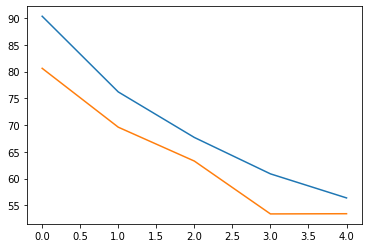

In [38]:
import matplotlib.pyplot as plt
plt.plot(history_2.history['mean_absolute_percentage_error'])
plt.plot(history_2.history['val_mean_absolute_percentage_error'])

In [39]:
res = model_2.evaluate(X_test, y_test, verbose=1)

print(f'MAPE on the test set : {res[1]:.0f} %')

4/4 [==============================] - 0s 54ms/step - loss: 0.4625 - mean_absolute_percentage_error: 66.6802
MAPE on the test set : 67 %


In [40]:
predictions_2 = model_2.predict(X_test)
predictions_2.shape

(100, 6)

In [41]:
predictions_2

array([[ 0.01491982,  0.20636359, -0.07669406,  0.54357874,  0.61181664,
         0.6028243 ],
       [ 0.02400365,  0.20343667, -0.0618988 ,  0.51883596,  0.5824222 ,
         0.5740503 ],
       [ 0.01891498,  0.2050763 , -0.07018696,  0.5326966 ,  0.5988887 ,
         0.5901692 ],
       [ 0.03020996,  0.20143694, -0.0517903 ,  0.501931  ,  0.5623392 ,
         0.55439126],
       [ 0.02569857,  0.20289055, -0.05913821,  0.5142193 ,  0.5769376 ,
         0.5686815 ],
       [ 0.02825078,  0.2037544 , -0.09472954,  0.5319683 ,  0.6230023 ,
         0.639483  ],
       [ 0.02012677,  0.20550308, -0.08747742,  0.54136723,  0.6212956 ,
         0.6245631 ],
       [ 0.03020996,  0.20143694, -0.0517903 ,  0.501931  ,  0.5623392 ,
         0.55439126],
       [ 0.02568427,  0.20289516, -0.05916151,  0.51425827,  0.5769839 ,
         0.56872684],
       [ 0.0241217 ,  0.20339864, -0.06170654,  0.5185144 ,  0.5820402 ,
         0.5736764 ],
       [ 0.01487073,  0.20637941, -0.07677402,  0.

In [49]:
#unscaled_predictions_2 = scaler.inverse_transform(predictions_2)
#unscaled_predictions_2[0:10] # showing 10 predictions in the test set out of 100 

In [51]:
#error = y_test.reshape(-1,1)-unscaled_predictions_2

In [52]:
#adapt on lenth of df
X, y = get_X_y(data_scaled, len(df), 30, ticker)
X.shape, y.shape

NameError: name 'df' is not defined

In [53]:
data_scaled.reset_index(inplace=True)

In [ ]:
df_true_pred.to_csv(f"LSTM_3features_{ticker}")

## Trying to test the predicton on the whole dataset

In [54]:
start = data_scaled[-29:]
test_arr = np.array(test)
test_arr  =test_arr.reshape((1,29,3))

NameError: name 'test' is not defined

In [ ]:
test_arr.shape

In [ ]:
predictions_X = model_2.predict(test_arr)
predictions_X

In [ ]:
unscaled_predictions_X = scaler.inverse_transform(predictions_X)
unscaled_predictions_X

In [57]:
data_scaled.head()

,date,GOOGL,news_label,twitter_label
0,2020-11-02,0.000000,0.0,-1.0
1,2020-11-03,0.015549,0.0,-1.0
2,2020-11-06,0.098663,0.5,-1.0
3,2020-11-09,0.099894,1.0,-1.0
4,2020-11-12,0.086342,0.5,-1.0


In [ ]:
df_true_pred = test[[ticker]]
df_true_pred["predictions"]=unscaled_predictions_X
# df_true_pred["ticker"] = ticker

In [59]:
len(data_scaled)
data_scaled.set_index(["date"], inplace=True)

In [60]:
X_final = []
for i in range(1,len(data_scaled)-29):
    arr = data_scaled.iloc[i:i+29]
    arr = np.array(arr)
    X_final.append(arr)
print(X_final)

[array([[ 0.01554884,  0.        , -1.        ],
       [ 0.09866297,  0.5       , -1.        ],
       [ 0.09989435,  1.        , -1.        ],
       [ 0.08634194,  0.5       , -1.        ],
       [ 0.10779263,  0.        , -1.        ],
       [ 0.10006922,  0.        , -1.        ],
       [ 0.09781777,  1.        , -1.        ],
       [ 0.08652046,  1.        , -1.        ],
       [ 0.07522314,  0.66666667, -1.        ],
       [ 0.10170134,  0.        , -1.        ],
       [ 0.10186892,  1.        , -1.        ],
       [ 0.1094539 ,  1.        ,  0.2       ],
       [ 0.11703887,  0.        ,  0.        ],
       [ 0.12462385,  1.        ,  0.76470588],
       [ 0.14041313,  0.5       ,  0.88888889],
       [ 0.11187293,  1.        ,  0.25      ],
       [ 0.10964334,  0.        ,  0.85714286],
       [ 0.09964662,  1.        ,  0.8       ],
       [ 0.09681227,  0.        ,  0.63636364],
       [ 0.06987504,  0.        ,  0.6       ],
       [ 0.08003206,  0.        ,  0.  

In [61]:
np.shape(X_final)

(312, 29, 3)

In [ ]:
X_final[10]

In [64]:
predictions_X_final = []
for i in range(0,10):
    reshaped = X_final[i].reshape(1,29,3)
    predictions = model_2.predict(reshaped)
    #print(f"mean : {np.mean(predictions)}")
    #predictions_unscaled = scaler.inverse_transform(predictions)
    predictions_X_final.append(predictions)
    #print(f"mean : {np.mean(predictions)}")
    
predictions_X_final

[array([[0.1621478 , 0.1594837 , 0.16440171, 0.14007998, 0.13363943,
         0.13432574]], dtype=float32),
 array([[0.15943164, 0.16074643, 0.16547309, 0.13874216, 0.13237318,
         0.13268523]], dtype=float32),
 array([[0.16157302, 0.15985757, 0.16453908, 0.13983962, 0.13368383,
         0.13421327]], dtype=float32),
 array([[0.16003783, 0.1612006 , 0.16461737, 0.1393358 , 0.13481125,
         0.13467081]], dtype=float32),
 array([[0.16090922, 0.160722  , 0.16433524, 0.13973552, 0.13500226,
         0.13503541]], dtype=float32),
 array([[0.16075917, 0.16087203, 0.16432717, 0.13969378, 0.13516736,
         0.13512139]], dtype=float32),
 array([[0.1612945 , 0.1603368 , 0.16435592, 0.13984267, 0.13457832,
         0.13481465]], dtype=float32),
 array([[0.1621301 , 0.1595014 , 0.16440076, 0.14007504, 0.1336589 ,
         0.13433589]], dtype=float32),
 array([[0.16117437, 0.16045691, 0.16434947, 0.13980927, 0.1347105 ,
         0.13488348]], dtype=float32),
 array([[0.16117176, 0.16020

In [ ]:
reshaped_1 = X_final[5].reshape(1,29,3)

In [ ]:
predictions_1 = model_2.predict(reshaped_1)

In [ ]:
predictions_1

In [ ]:
reshaped_2 = X_final[50].reshape(1,29,3)

In [ ]:
predictions_2 = model_2.predict(reshaped_2)

In [ ]:
predictions_2

In [ ]:
predictions_X_final.shape